# 1. Load dataset
#### In this notebook, We try to build a model that finds clusters in the given face images dataset.
#### We will need to read the data from the archive file (faces.zip). It contains 400 images of 40 persons. Each image is 64x64. zipfile is used for extracting the images, os for iterating the files and PIL for reading the images. Person labels are in the file names. Making sure that the order of images and labels are preserved.

In [1]:
import os
import zipfile

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV

In [2]:
# Unzip the folder
with zipfile.ZipFile('faces.zip') as archive:
    archive.extractall('faces')

In [3]:
os.chdir('faces/')

In [4]:
# this list will hold all the faces
faces = []

with os.scandir() as files:
    for file in files:
        if file.name.endswith('.png'):
            faces.append(file.name)

## Forming the dataset

In [5]:
rows, labels = [], []

for face in faces:
    img = Image.open(face)
    pixel_values = list(img.getdata())
    
    rows.append(pixel_values)
    labels.append(int(face.split('_')[0]))

# Form the dataset with each row being image itself and each column column being a single pixel value of the image
df = pd.DataFrame(rows)

# 2. Prepare dataset
#### Normalize the dataset (for this instance, we should normalize the whole dataset before split). Split the dataset into train (280 instances), validation (80 instances) and test sets (40 instances). When splitting, make sure there are same number of images per person in each set.

In [6]:
# Scale the pixel range to 0 - 1
norm_df = df.apply(lambda x: x/255)

In [7]:
X, y = norm_df, np.array(labels)

In [8]:
# Used stratisfied shuffle to split classes evenly. Needed two split for validation and test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=9)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=9)

In [9]:
# train test split
train_index, test_index = list(sss.split(X, y))[0]

X_train_val, y_train_val = X.iloc[train_index], y[train_index]
X_test, y_test = X.iloc[test_index], y[test_index]

In [10]:
# train validation split
tr_index, val_index = list(sss_val.split(X_train_val, y_train_val))[0]

X_train, y_train = X_train_val.iloc[tr_index], y_train_val[tr_index]
X_val, y_val = X_train_val.iloc[val_index], y_train_val[val_index]

In [11]:
X_train.shape

(280, 4096)

In [12]:
X_val.shape

(80, 4096)

In [13]:
X_test.shape

(40, 4096)

In [14]:
# Prove that the data is splitted in a balanced way
np.sort(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [15]:
# X_train

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
23,0.231373,0.282353,0.349020,0.431373,0.470588,0.509804,0.549020,0.572549,0.580392,0.600000,...,0.666667,0.635294,0.509804,0.223529,0.160784,0.168627,0.180392,0.180392,0.172549,0.180392
291,0.752941,0.749020,0.741176,0.745098,0.749020,0.745098,0.745098,0.745098,0.745098,0.749020,...,0.352941,0.274510,0.113725,0.125490,0.262745,0.349020,0.352941,0.305882,0.298039,0.341176
256,0.125490,0.192157,0.392157,0.517647,0.568627,0.568627,0.560784,0.545098,0.541176,0.556863,...,0.239216,0.247059,0.250980,0.250980,0.266667,0.278431,0.294118,0.298039,0.298039,0.305882
105,0.498039,0.486275,0.525490,0.517647,0.529412,0.525490,0.572549,0.627451,0.643137,0.623529,...,0.145098,0.149020,0.231373,0.294118,0.262745,0.250980,0.250980,0.262745,0.247059,0.266667
8,0.580392,0.690196,0.705882,0.725490,0.725490,0.733333,0.733333,0.756863,0.760784,0.749020,...,0.482353,0.505882,0.474510,0.192157,0.031373,0.192157,0.380392,0.352941,0.454902,0.635294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,0.129412,0.101961,0.086275,0.109804,0.109804,0.113725,0.172549,0.396078,0.556863,0.596078,...,0.450980,0.450980,0.466667,0.478431,0.443137,0.439216,0.431373,0.423529,0.447059,0.431373
24,0.411765,0.454902,0.494118,0.537255,0.560784,0.576471,0.592157,0.600000,0.615686,0.611765,...,0.419608,0.423529,0.431373,0.439216,0.443137,0.380392,0.494118,0.627451,0.529412,0.419608
250,0.400000,0.439216,0.462745,0.474510,0.498039,0.490196,0.498039,0.537255,0.525490,0.498039,...,0.592157,0.650980,0.650980,0.643137,0.647059,0.670588,0.466667,0.286275,0.419608,0.470588
2,0.313725,0.333333,0.349020,0.356863,0.407843,0.443137,0.521569,0.580392,0.627451,0.658824,...,0.552941,0.666667,0.709804,0.666667,0.733333,0.729412,0.717647,0.568627,0.701961,0.745098


# 3. PCA
#### Apply PCA on the data while preserving 99% of the variance.

In [16]:
pca_breast = PCA(n_components=200)

pca_trans = pca_breast.fit_transform(X_train)

In [17]:
variance = sum(pca_breast.explained_variance_ratio_)
# variance

In [18]:
pca_val = pca_breast.transform(X_val)

In [19]:
pca_test = pca_breast.transform(X_test)

In [20]:
pca_df = pca_breast.transform(X)

# 4. Clustering
#### Apply k-means clustering with different k values (e.g., from 5 to 150, with step size of 5).  Also, saving the models for later use.

In [21]:
dist = []
k_means_models = []

for k in range(5, 151, 5):
    k_means = KMeans(
        init="random",
        n_clusters=k,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    
    k_means.fit_transform(pca_trans)
    
    # Log the distance for Elbow and model itself for further evaluation     
    dist.append(k_means.inertia_)
    k_means_models.append(k_means)

In [22]:
for i in k_means_models:
    print('Score: ', i.score(pca_test, y_test))

Score:  -1701.9479301608715
Score:  -1486.9958377097828
Score:  -1411.956087142115
Score:  -1432.971454107749
Score:  -1328.4887478106436
Score:  -1288.0294449513308
Score:  -1288.7232557245188
Score:  -1194.2872754613472
Score:  -1192.8055838517503
Score:  -1206.790025651237
Score:  -1079.086983524125
Score:  -1136.2191957764317
Score:  -1086.6240119007095
Score:  -1088.2467774036381
Score:  -1073.6480712922942
Score:  -1081.2774822128288
Score:  -1045.2719952758214
Score:  -965.0826243454517
Score:  -946.715983182848
Score:  -948.2151060291848
Score:  -966.7991397607782
Score:  -964.1235745628315
Score:  -956.9327118784734
Score:  -971.6473807885386
Score:  -962.3262423517033
Score:  -963.3394376409149
Score:  -942.6988637920206
Score:  -936.0465734125617
Score:  -923.7647983793956
Score:  -922.41335439172


# 5. Analysis
#### Draw the elbow plot and silhouette scores plot.

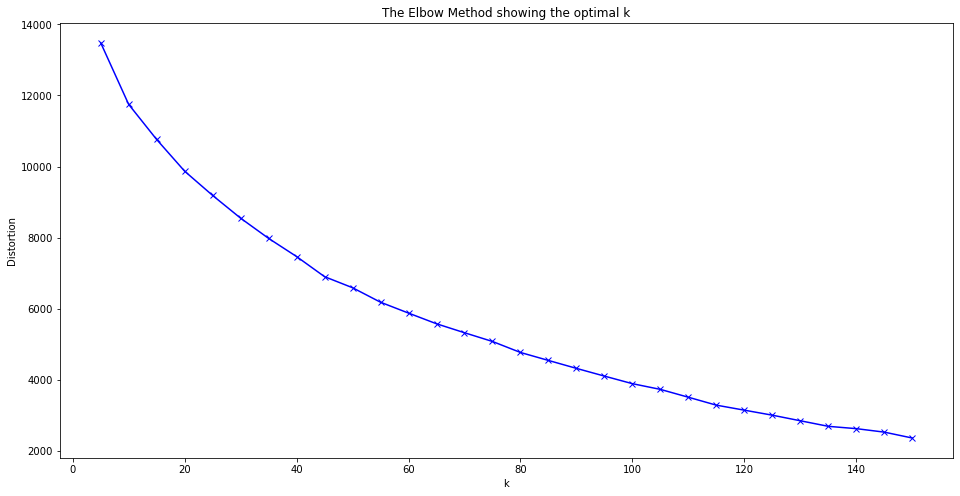

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(range(5, 151, 5), dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [24]:
# Best model is approximately when k=80 which is 15th indexed model
df_trans = k_means_models[15].transform(pca_df)

In [26]:
min_distances = df_trans.min(axis=1)
# min_distances, which will be used to add a new feature for classification algorithm

In [27]:
# Silhouette score calculation
scores = []

for model, idx in zip(k_means_models, range(5, 151, 5)):
    val_score = silhouette_score(pca_val, model.predict(pca_val))
    test_score = silhouette_score(pca_test, model.predict(pca_test))
    
#     print('Silhouette Score for validation data: ', val_score)
#     print('Silhouette Score for test data: ', test_score)
    
    scores.append([val_score, test_score, idx])

In [28]:
# Best Silhouette scores for validation dataset
sorted(scores, reverse=True, key=lambda x: x[0])[:6]

[[0.10669091848241899, 0.09449575409589042, 5],
 [0.08761999420168973, 0.002447415282558957, 55],
 [0.08587173009756506, 0.02806624075687141, 40],
 [0.0826442880806995, -0.014953382331185386, 50],
 [0.08031378714195489, 0.01779646991012896, 45],
 [0.07997852098423343, -0.03336436540765745, 65]]

#### Visualize the clusters (for 40 clusters and best k that we found from silhouette scores) to see whether there are similar faces in each cluster.

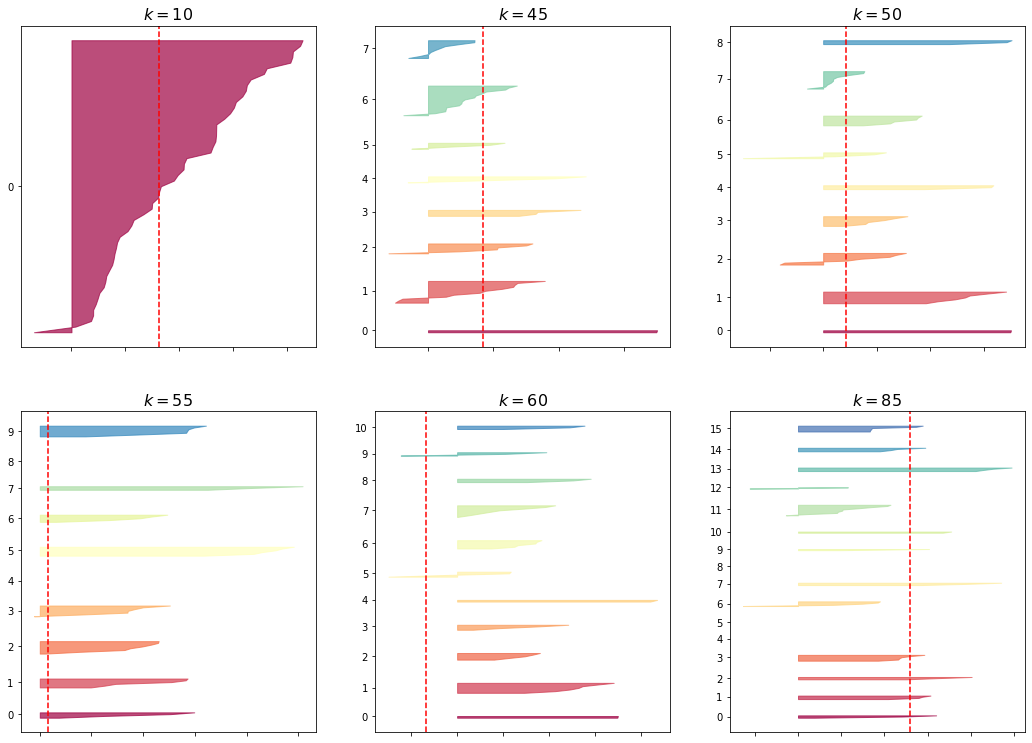

In [45]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(18, 13))

for idx, k in enumerate((1, 8, 9, 10, 11, 16)):
    plt.subplot(2, 3, idx + 1)

    y_pred = k_means_models[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_train, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_coefficients[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format((k + 1)*5), fontsize=16)

plt.show()

# 6. Classification
#### Train a classifier on the train data to predict person on the image.

#### Use best k-means model as a dimensionality reduction technique to reduce the dataset and train a classifier on the reduced data. Data will have shape (280, number of clusters in the best model).

#### Create a pipeline to reduce the data (with k-means) with different numbers of clusters and train a classifier. Find out which value of k gives the best classification result.

In [30]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('random_forest', RandomForestClassifier())
    ]
)

In [31]:
# If multiple preprocessing is done inside pipeline, the hyperparameters should be 
# given as: <estimator_name>__<hyper_parameter>
pipe_params = {
    'pca__n_components': [20, 30, 40, 50, 60, 100, 200],
    'random_forest__n_estimators': [100, 200, 300, 400], 
    'random_forest__max_depth': [5, 7, 9, 11, 13, 15],
    'random_forest__criterion': ['gini', 'entropy']
}

pipe_clf = RandomizedSearchCV(pipe, pipe_params, cv=5)

In [32]:
# Find the best model hyperparameters
pipe_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('random_forest',
                                              RandomForestClassifier())]),
                   param_distributions={'pca__n_components': [20, 30, 40, 50,
                                                              60, 100, 200],
                                        'random_forest__criterion': ['gini',
                                                                     'entropy'],
                                        'random_forest__max_depth': [5, 7, 9,
                                                                     11, 13,
                                                                     15],
                                        'random_forest__n_estimators': [100,
                                                                        200,
     

In [33]:
pipe_clf.best_params_

{'random_forest__n_estimators': 300,
 'random_forest__max_depth': 13,
 'random_forest__criterion': 'entropy',
 'pca__n_components': 50}

In [34]:
# Accuracy on the validation data
pipe_clf.score(X_val, y_val)

0.95

In [35]:
# Accuracy on the test data
pipe_clf.score(X_test, y_test)

0.975

#### Add new features to original set of features and check again to see whether better result than the case without new features can be achieved?

In [36]:
# prevent feature warning: Got feature names with dtypes: ['int', 'str']
X[4096] = min_distances

In [37]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,0.360784,0.419608,0.458824,0.517647,0.552941,0.596078,0.615686,0.643137,0.654902,0.674510,...,0.149020,0.156863,0.141176,0.156863,0.164706,0.164706,0.164706,0.164706,0.164706,6.004826
1,0.458824,0.498039,0.525490,0.552941,0.576471,0.592157,0.607843,0.627451,0.635294,0.639216,...,0.333333,0.243137,0.262745,0.262745,0.270588,0.266667,0.262745,0.266667,0.266667,5.480865
2,0.313725,0.333333,0.349020,0.356863,0.407843,0.443137,0.521569,0.580392,0.627451,0.658824,...,0.666667,0.709804,0.666667,0.733333,0.729412,0.717647,0.568627,0.701961,0.745098,5.982345
3,0.474510,0.509804,0.501961,0.498039,0.525490,0.576471,0.607843,0.619608,0.627451,0.650980,...,0.250980,0.247059,0.317647,0.400000,0.325490,0.454902,0.494118,0.568627,0.364706,3.707716
4,0.360784,0.219608,0.231373,0.501961,0.752941,0.733333,0.737255,0.745098,0.737255,0.776471,...,0.211765,0.243137,0.152941,0.156863,0.223529,0.188235,0.176471,0.168627,0.164706,3.057324


In [38]:
X_train_val, y_train_val = X.iloc[train_index], y[train_index]
X_test, y_test = X.iloc[test_index], y[test_index]

In [39]:
X_train, y_train = X_train_val.iloc[tr_index], y_train_val[tr_index]
X_val, y_val = X_train_val.iloc[val_index], y_train_val[val_index]

## New classifier with additional feature

In [40]:
pipe2_clf = RandomizedSearchCV(pipe, pipe_params, cv=5)

In [41]:
# Find the best model hyperparameters
pipe2_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('random_forest',
                                              RandomForestClassifier())]),
                   param_distributions={'pca__n_components': [20, 30, 40, 50,
                                                              60, 100, 200],
                                        'random_forest__criterion': ['gini',
                                                                     'entropy'],
                                        'random_forest__max_depth': [5, 7, 9,
                                                                     11, 13,
                                                                     15],
                                        'random_forest__n_estimators': [100,
                                                                        200,
     

In [42]:
pipe2_clf.best_params_

{'random_forest__n_estimators': 300,
 'random_forest__max_depth': 5,
 'random_forest__criterion': 'entropy',
 'pca__n_components': 200}

In [43]:
pipe2_clf.score(X_val, y_val)

0.9625

In [44]:
pipe2_clf.score(X_test, y_test)

0.975

***Notes***
- Model performance increased from 0.95 to 0.975 when introduced with extra feature of min distances to each centroid
- Best parameters for model also changed in accordance with new feature